In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import copy
import time
import cv2 
import numpy as np 
import random

from copy import deepcopy 
from collections import deque, defaultdict
from typing import Any, Dict, List, Optional, Set, Tuple, Union
from numpy.typing import ArrayLike, NDArray

import dm_control
from dm_control import mujoco as dm_mujoco
from dm_control.utils.transformations import mat_to_quat, quat_to_euler, euler_to_quat
import mujoco
from rocobench.envs import SortOneBlockTask, CabinetTask, MoveRopeTask, SweepTask, MakeSandwichTask, PackGroceryTask, MujocoSimEnv, SimRobot, visualize_voxel_scene

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
basic imports
local modules


In [17]:
def cross(a, b):
    return np.cross(a, b)

target = np.array([1, 0, 0])
positions = [np.array([1.25, 0.7, 1])]
for position in positions:
    vector = target - position
    cross_product = cross(vector, np.array([0, 0, 1]))
    # Calculate the unit vectors x and y
    x = cross_product / np.linalg.norm(cross_product)
    x = x/np.linalg.norm(x)
    y = np.cross(vector, x)
    y = y/np.linalg.norm(y)
    cpstring = " ".join([f"{i:.3f}" for i in position])
    xystring = " ".join([f"{i:.3f}" for i in y]) + " " + " ".join([f"{i:.3f}" for i in x])
    print(f"""<camera mode="trackcom" name='object_ pchdr' pos="{cpstring}" xyaxes="{xystring}"/>""")

<camera mode="trackcom" name='object_ pchdr' pos="1.250 0.700 1.000" xyaxes="0.270 0.756 -0.597 -0.942 0.336 0.000"/>


In [97]:
tracked = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'ur5e', 'panda', 'table']
# tracked = ["bread"]
env = PackGroceryTask(
    render_freq=2000,
    image_hw=(400,400), # Potentially important for getting RGBD images later on
    sim_forward_steps=300, # number of time steps forward that mujoco simulates before deciding that the llms need to pick an easier to optimize plan
    error_freq=30,
    error_threshold=1e-5,
    randomize_init=True,
    render_point_cloud=0, # Potentially useful for speeding up point fusion
    render_cameras=["face_panda","face_ur5e","teaser",],
    point_feature_cameras=tracked,
    one_obj_each=True, # TODO: Understand this
)

in init loading visual encoder
loading physics
rendering cameras
face_panda
face_ur5e
teaser
sceneshotcam
apple
milk
cereal
bread
banana
bin
ur5e
panda
table
resetting


In [63]:
from dm_control.utils.transformations import euler_to_quat

print(euler_to_quat([90, 0, 0], 'XYZ'))

[0.52532199 0.85090352 0.         0.        ]


In [98]:
import numpy as np
from dm_control.utils.transformations import euler_to_quat
# with env.physics.reset_context():
#     rotation = [0, 0, 0]
#     quat = euler_to_quat(list(map(np.radians, rotation)), 'XYZ')
#     env.model.body(46).quat = quat

env.physics.forward()
# env.physics.step()
outputs = env.render_feature_cameras()



In [99]:
for cam in tracked:
    rgbimg = Image.fromarray(outputs[cam][1])
    rgbimg.save(f'rocobench/test_images/outputs/{cam}.png')

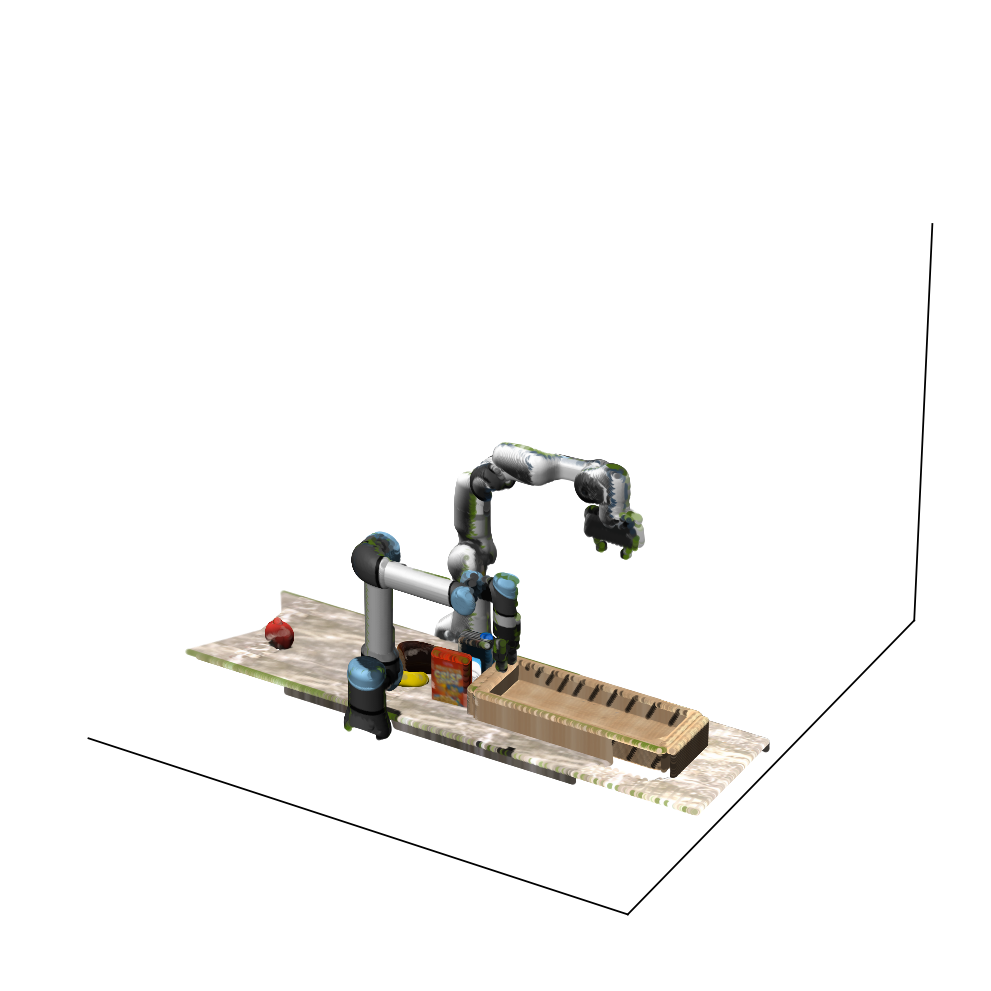

(1151815, 3)


In [100]:
SCENE_BOUNDS=((-1.4, -0.2, -0.1), (1.7, 1.2, 1.1))
point_clouds = [
    sensor_output[0].point_cloud.filter_bounds(bounds=SCENE_BOUNDS) 
        for sensor_output in outputs.values()
]
global_point_cloud = sum(point_clouds[1:], start=point_clouds[0])
global_point_cloud.show()
print(global_point_cloud.normals.shape)

In [101]:
from PIL import Image
for key in outputs:
    outputs[key] = outputs[key][1]

outputs['xyz_pts'] = global_point_cloud.xyz_pts
outputs['segmentation_pts'] = global_point_cloud.segmentation_pts
outputs['rgb_pts'] = global_point_cloud.rgb_pts
outputs['normals'] = global_point_cloud.normals

import pickle

with open('outputs.pkl', 'wb') as f:
    pickle.dump(outputs, f)

In [ ]:
pointcloud = env.get_point_cloud()

In [ ]:
pointcloud.show()

In [ ]:
import cv2
img = cv2.imread("rgb_image_sceneshot.png")
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
h, w = img.shape[:2]

focal_length = w / (2 * np.tan(45 * np.pi / 180))
K = np.array([[focal_length, 0, w / 2],
                  [0, focal_length, h / 2],
                  [0, 0, 1]])
dist_coeffs = np.zeros(4)
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (w, h), 1, (w, h))
undistorted_img = cv2.undistort(img, K, dist_coeffs, None, new_camera_matrix)
x, y, w, h = roi
undistorted_img = undistorted_img[y:y+h, x:x+w]
cv2.imwrite("undistorted_sceneshot.png", undistorted_img)

In [ ]:
obj = "cereal"
minx = min(pointcloud[obj].xyz_pts[:,0])
maxx = max(pointcloud[obj].xyz_pts[:,0])
miny = min(pointcloud[obj].xyz_pts[:,1])
maxy = max(pointcloud[obj].xyz_pts[:,1])
minz = min(pointcloud[obj].xyz_pts[:,2])
maxz = max(pointcloud[obj].xyz_pts[:,2])
width = maxx - minx
height = maxy - miny
depth = maxz - minz

# Find the maximum dimension
max_dim = max(width, height, depth)

# Calculate the center of the bounding box
center_x = (minx + maxx) / 2
center_y = (miny + maxy) / 2
center_z = (minz + maxz) / 2

# Calculate the minimum and maximum coordinates of the bounding box
bbox_min = (center_x - max_dim/2, center_y - max_dim/2, center_z - max_dim/2)
bbox_max = (center_x + max_dim/2, center_y + max_dim/2, center_z + max_dim/2)
bounds = (bbox_min, bbox_max)
pointcloud[obj].show(pts_size=50, bounds=bounds)

In [ ]:
print(f"|{env.model.id2name(48, 'body')}|")
print(env.model.geom(171))
print(f"|{env.model.name2id('apple_visual', 'geom')}|")